In [1]:
import torch, os
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
from torch.autograd import Variable
from torch.utils.data import DataLoader
from torchvision.datasets import ImageFolder
from torchvision import transforms
from utils import create_dataloader
from torchvision.utils import make_grid
from IPython.display import clear_output

### Creating config object (argparse workaround)

In [2]:
class Config:
    pass

config = Config()
config.mnist_path = None
config.batch_size = 16
config.num_workers = 3
config.num_epochs = 10
config.noise_size = 50
config.print_freq = 100


### Create dataloder

In [3]:
dataloader = create_dataloader(config)

In [4]:
len(dataloader)

3750

In [5]:
for image, cat in dataloader:
    break  

In [6]:
im = image.numpy()[0,0,:,:]
im.resize(28*28)
print(im.shape)
im.resize(28,28)

(784,)


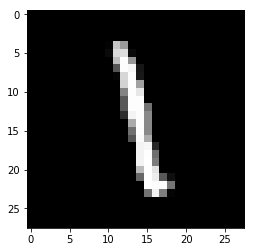

In [7]:
plt.imshow(im, cmap=plt.cm.Greys_r)  

In [8]:
image.resize_(28*28)
image.size()

torch.Size([784])

In [9]:
28*28

784

### Create generator and discriminator

In [10]:
class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()
        self.model = nn.Sequential( 
            nn.Linear(config.noise_size, 200),
            nn.ReLU(inplace=True),
            nn.Linear(200, 28*28),
            nn.Sigmoid())
        
    def forward(self, x):
        return self.model(x)
    
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(28*28, 200),
            nn.ReLU(inplace=True),
            nn.Linear(200, 50),
            nn.ReLU(inplace=True),
            nn.Linear(50, 1), 
            nn.Sigmoid())
    def forward(self, x):
        return self.model(x)

In [11]:
generator = Generator()
discriminator = Discriminator()

### Create optimizers and loss

In [12]:
optim_G = optim.Adam(params=generator.parameters(), lr=0.0001)
optim_D = optim.Adam(params=discriminator.parameters(), lr=0.0001)

criterion = nn.BCELoss()

### Create necessary variables

In [13]:
input = Variable(torch.FloatTensor(config.batch_size, 28*28))
noise = Variable(torch.FloatTensor(config.batch_size, config.noise_size))
fixed_noise = Variable(torch.FloatTensor(config.batch_size, config.noise_size).normal_(0, 1))
label = Variable(torch.FloatTensor(config.batch_size))
real_label = 1
fake_label = 0

### Задание

1) Посмотрите на реализацию GAN

2) Поменяйте ее, чтобы получился LSGAN https://arxiv.org/pdf/1611.04076v2.pdf

3) Попробуйте оба GAN и LSGAN на CelebA http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html

4) Напишите отчет что попробовали, какие результаты получили, как вам кажется надо обучать GAN, чтобы добиться сходимости?

Обязательны графики.

### GAN

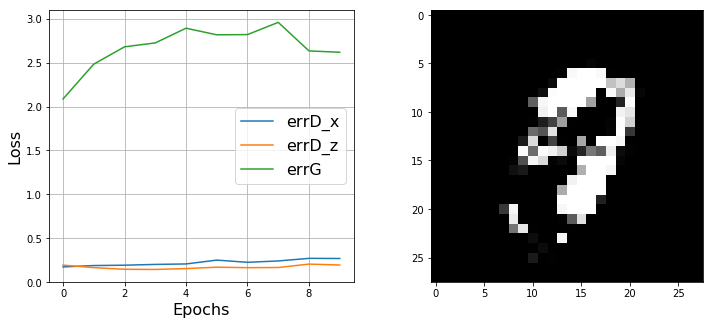

In [14]:
errDx_loss_epochs_global = []
errDz_loss_epochs_global = []
errG_loss_epochs_global = []

for epoch in range(config.num_epochs):
    
    errDx_loss_epochs = []
    errDz_loss_epochs = []
    errG_loss_epochs = []
    sample = None
    
    
    for iteration, (images, cat) in enumerate(dataloader):
        ####### 
        # Discriminator stage: maximize log(D(x)) + log(1 - D(G(z))) 
        #######
        discriminator.zero_grad()
        
        # real
        label.data.fill_(real_label)
        input.data.copy_(images.resize_(28*28))
        output = discriminator(input)
        errD_x = criterion(output, label)
        errDx_loss_epochs.append(errD_x.item())
        errD_x.backward()
        
        # fake 
        noise.data.normal_(0, 1)
        fake = generator(noise)
        sample = fake
        label.data.fill_(fake_label)
        output = discriminator(fake.detach())
        errD_z = criterion(output, label)
        errDz_loss_epochs.append(errD_z.item())
        errD_z.backward()
        
        optim_D.step()
        
        ####### 
        # Generator stage: maximize log(D(G(x))
        #######
        generator.zero_grad()
        label.data.fill_(real_label)
        output = discriminator(fake)
        errG = criterion(output, label)
        errG_loss_epochs.append(errG.item())
        errG.backward()
        
        optim_G.step()
        
        
        if (iteration+1) % config.print_freq == 0:
            print('Epoch:{} Iter: {} errD_x: {:.2f} errD_z: {:.2f} errG: {:.2f}'.format(epoch+1,
                                                                                            iteration+1, 
                                                                                            errD_x.data[0],
                                                                                            errD_z.data[0], 
                                                                                        errG.data[0]))
            
    errDx_loss_epochs_global.append(np.mean(errDx_loss_epochs))        
    errDz_loss_epochs_global.append(np.mean(errDz_loss_epochs))        
    errG_loss_epochs_global.append(np.mean(errG_loss_epochs)) 
    
    if epoch % 1 == 0:
        
        clear_output(True)
        #print('\rEpoch {0}... (Train/Test) MSE: {1:.5f}/{2:.5f}'.format(
        #                    epoch, train_loss_epochs[-1], test_loss_epochs[-1]))
                    
        plt.figure(figsize=(12, 5))
        plt.subplot(1, 2, 1)
        plt.plot(errDx_loss_epochs_global, label='errD_x')
        plt.plot(errDz_loss_epochs_global, label='errD_z')
        plt.plot(errG_loss_epochs_global, label='errG')
        plt.xlabel('Epochs', fontsize=16)
        plt.ylabel('Loss', fontsize=16)
        plt.legend(loc=0, fontsize=16)
        plt.grid()
                    
            
        plt.subplot(1, 2, 2)
        im = fake.detach().numpy()[0]
        im.resize(28,28)
        plt.imshow(im, cmap=plt.cm.Greys_r)
        plt.show()                   

In [15]:
#хак - заморозка на время генератора/дискриминатора, пока они не сравняются по функции потерь 

In [17]:
image_size = 28
print_freq = 10
batch_size = 10
noise_size = 100

class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()
        self.model = nn.Sequential( 
            
            nn.ConvTranspose2d(100, 256, kernel_size=(4, 4), stride=(1, 1)),
            nn.LeakyReLU(0.05),
            nn.ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1)),
            nn.BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True),
            nn.LeakyReLU(0.05),
            nn.ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1)),
            nn.BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True),
            nn.LeakyReLU(0.05),
            nn.ConvTranspose2d(64, 28, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1)),
            nn.BatchNorm2d(28, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True),
            nn.LeakyReLU(0.05),
            nn.ConvTranspose2d(28, 1, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1)),
            nn.Tanh()
            )
        
    def forward(self, x):
        x = x.view(x.size(0), x.size(1), 1, 1)
        return self.model(x)
    
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.model = nn.Sequential(
            nn.Conv2d(1, 28, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1)),
            nn.LeakyReLU(0.05),
            nn.Conv2d(28, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1)),
            nn.BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True),
            nn.LeakyReLU(0.05),
            nn.Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1)),
            nn.BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True),
            nn.LeakyReLU(0.05),
            nn.Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1)),
            nn.BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True),
            nn.Conv2d(256, 1, kernel_size=(4, 4), stride=(1, 1)),
            nn.Sigmoid())
        
    def forward(self, x):
        res = self.model(x).squeeze()
        res = res.view(res.size(0))
        return res

In [18]:
generator = Generator()
discriminator = Discriminator()

In [19]:
optim_G = optim.Adam(params=generator.parameters(), lr=0.0001)
optim_D = optim.Adam(params=discriminator.parameters(), lr=0.0001)

criterion = nn.MSELoss()

In [20]:
input = Variable(torch.FloatTensor(batch_size, 28*28))
noise = Variable(torch.FloatTensor(batch_size, noise_size))
fixed_noise = Variable(torch.FloatTensor(batch_size, noise_size).normal_(0, 1))
label = Variable(torch.FloatTensor(batch_size))
real_label = 1
fake_label = 0
c_label = 1

In [22]:
errDx_loss_epochs_global = []
errDz_loss_epochs_global = []
errG_loss_epochs_global = []

for epoch in range(100):#config.num_epochs):
    
    errDx_loss_epochs = []
    errDz_loss_epochs = []
    errG_loss_epochs = []
    sample = None
    
    
    for iteration, (images, cat) in enumerate(dataloader):
        ####### 
        # Discriminator stage: maximize log(D(x)) + log(1 - D(G(z))) 
        #######
        discriminator.zero_grad()
        
        # real
        label.data.fill_(real_label)
        #input.data.copy_(images.resize_(28*28))
        output = discriminator(images)
        errD_x = criterion(output, label)
        errDx_loss_epochs.append(errD_x.item())
        errD_x.backward()
        
        
        # fake 
        noise.data.normal_(-1, 1)
        fake = generator(noise)
        sample = fake[0]
        label.data.fill_(fake_label)
        output = discriminator(fake.detach())
        errD_z = criterion(output, label)
        errDz_loss_epochs.append(errD_z.item())
        errD_z.backward()
        
        optim_D.step()
        
        ####### 
        # Generator stage: maximize log(D(G(x))
        #######
        generator.zero_grad()
        label.data.fill_(c_label)
        output = discriminator(fake)
        errG = criterion(output, label)
        errG_loss_epochs.append(errG.item())
        errG.backward()
        
        optim_G.step() 
        
      
        
        if (iteration+1) % print_freq == 0:
            print('Epoch:{} Iter: {} errD_x: {:.5f} errD_z: {:.5f} errG: {:.5f}'.format(epoch+1,
                                                                                            iteration+1, 
                                                                                            errD_x.data[0],
                                                                                            errD_z.data[0], 
                                                                                        errG.data[0]))
            
    errDx_loss_epochs_global.append(np.mean(errDx_loss_epochs))        
    errDz_loss_epochs_global.append(np.mean(errDz_loss_epochs))        
    errG_loss_epochs_global.append(np.mean(errG_loss_epochs)) 
    #im = (fake.detach().numpy()[0]).reshape(64,64, 3 )
    #print im.shape
    #im.resize(6,28)
    plt.imshow(denorm(sample.permute(1, 2, 0).detach()).numpy())
    #plt.imshow(im, cmap=plt.cm.Greys_r
    plt.show()
    if epoch % 1 == 0:
        pass
        #clear_output(True)
        #print('\rEpoch {0}... (Train/Test) MSE: {1:.5f}/{2:.5f}'.format(
        #                    epoch, train_loss_epochs[-1], test_loss_epochs[-1]))
                    
        #plt.figure(figsize=(12, 5))
        #plt.subplot(1, 2, 1)
        #plt.plot(train_loss_epochs, label='Train')
        #plt.plot(train_loss_epochs, label='Train')
        #plt.plot(test_loss_epochs, label='Test')
        #plt.xlabel('Epochs', fontsize=16)
        #plt.ylabel('Loss', fontsize=16)
        #plt.legend(loc=0, fontsize=16)
        #plt.grid()
                    
        #true, predicted = self.predict()        
        #plt.subplot(1, 2, 2)
        #plt.plot(true, label='True')
        #plt.plot(predicted, label='Prediction')
        #plt.legend()
        #plt.grid() 
        #plt.show()    

RuntimeError: Calculated padded input size per channel: (1 x 1). Kernel size: (4 x 4). Kernel size can't be greater than actual input size at /opt/conda/conda-bld/pytorch_1535488076166/work/aten/src/THNN/generic/SpatialConvolutionMM.c:48

In [23]:
errDx_loss_epochs_global = []
errDz_loss_epochs_global = []
errG_loss_epochs_global = []

for epoch in range(config.num_epochs):
    
    errDx_loss = [0]
    errDz_loss = [0]
    errG_loss = [0]
    sample = None
    
    
    for iteration, (images, cat) in enumerate(dataloader):
        ####### 
        # Discriminator stage: maximize log(D(x)) + log(1 - D(G(z))) 
        #######
        discriminator.zero_grad()
        
        # real
        label.data.fill_(real_label)
        input.data.copy_(images.resize_(28*28))
        output = discriminator(input)
        errD_x = criterion(output, label)
        errDx_loss.append(errD_x.item())
        if errDx_loss[-1] + 0.1 > errG_loss[-1]:
            errD_x.backward()
            optim_D.step()
        
        
        # fake 
        noise.data.normal_(0, 1)
        fake = generator(noise)
        sample = fake
        label.data.fill_(fake_label)
        output = discriminator(fake.detach())
        errD_z = criterion(output, label)
        errDz_loss.append(errD_z.item())
        if errDz_loss[-1] + 0.1 > errG_loss[-1]:
            errD_z.backward()
            optim_D.step()
        
        
        ####### 
        # Generator stage: maximize log(D(G(x))
        #######
        generator.zero_grad()
        label.data.fill_(real_label)
        output = discriminator(fake)
        errG = criterion(output, label)
        errG_loss.append(errG.item())
        #if errG_loss[-1] + 0.1 > errDz_loss[-1] or errG_loss[-1] + 0.1 > errDx_loss[-1]:
        errG.backward()
        optim_G.step()
        
        
        
        
        if (iteration+1) % config.print_freq == 0:
            print('Epoch:{} Iter: {} errD_x: {:.2f} errD_z: {:.2f} errG: {:.2f}'.format(epoch+1,
                                                                                            iteration+1, 
                                                                                            errD_x.data[0],
                                                                                            errD_z.data[0], 
                                                                                        errG.data[0]))
            
    errDx_loss_epochs_global.append(np.mean(errDx_loss))        
    errDz_loss_epochs_global.append(np.mean(errDz_loss))        
    errG_loss_epochs_global.append(np.mean(errG_loss)) 
    im = fake.detach().numpy()[0]
    im.resize(28,28)
    plt.imshow(im, cmap=plt.cm.Greys_r)
    plt.show()
    if epoch % 1 == 0:
        pass
        #clear_output(True)
        #print('\rEpoch {0}... (Train/Test) MSE: {1:.5f}/{2:.5f}'.format(
        #                    epoch, train_loss_epochs[-1], test_loss_epochs[-1]))
                    
        #plt.figure(figsize=(12, 5))
        #plt.subplot(1, 2, 1)
        #plt.plot(train_loss_epochs, label='Train')
        #plt.plot(train_loss_epochs, label='Train')
        #plt.plot(test_loss_epochs, label='Test')
        #plt.xlabel('Epochs', fontsize=16)
        #plt.ylabel('Loss', fontsize=16)
        #plt.legend(loc=0, fontsize=16)
        #plt.grid()
                    
        #true, predicted = self.predict()        
        #plt.subplot(1, 2, 2)
        #plt.plot(true, label='True')
        #plt.plot(predicted, label='Prediction')
        #plt.legend()
        #plt.grid() 
        #plt.show()                   

torch.Size([16])
torch.Size([16])
torch.Size([16])
torch.Size([16])
torch.Size([16])
torch.Size([16])
torch.Size([16])
torch.Size([16])
torch.Size([16])
torch.Size([16])
torch.Size([16])
torch.Size([16])
torch.Size([16])
torch.Size([16])
torch.Size([16])
torch.Size([16])
torch.Size([16])
torch.Size([16])
torch.Size([16])
torch.Size([16])
torch.Size([16])
torch.Size([16])
torch.Size([16])
torch.Size([16])
torch.Size([16])
torch.Size([16])
torch.Size([16])
torch.Size([16])
torch.Size([16])
torch.Size([16])
torch.Size([16])
torch.Size([16])
torch.Size([16])
torch.Size([16])
torch.Size([16])
torch.Size([16])
torch.Size([16])
torch.Size([16])
torch.Size([16])
torch.Size([16])
torch.Size([16])
torch.Size([16])
torch.Size([16])
torch.Size([16])
torch.Size([16])
torch.Size([16])
torch.Size([16])
torch.Size([16])
torch.Size([16])
torch.Size([16])
torch.Size([16])
torch.Size([16])
torch.Size([16])
torch.Size([16])
torch.Size([16])
torch.Size([16])
torch.Size([16])
torch.Size([16])
torch.Size([16

/home/alex/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:62: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number
/home/alex/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:63: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number
/home/alex/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:64: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


torch.Size([16])
torch.Size([16])
torch.Size([16])
torch.Size([16])
torch.Size([16])
torch.Size([16])
torch.Size([16])
torch.Size([16])
torch.Size([16])
torch.Size([16])
torch.Size([16])
torch.Size([16])
torch.Size([16])
torch.Size([16])
torch.Size([16])
torch.Size([16])
torch.Size([16])
torch.Size([16])
torch.Size([16])
torch.Size([16])
torch.Size([16])
torch.Size([16])
torch.Size([16])
torch.Size([16])
torch.Size([16])
torch.Size([16])
torch.Size([16])
torch.Size([16])
torch.Size([16])
torch.Size([16])
torch.Size([16])
torch.Size([16])
torch.Size([16])
torch.Size([16])
torch.Size([16])
torch.Size([16])
torch.Size([16])
torch.Size([16])
torch.Size([16])
torch.Size([16])
torch.Size([16])
torch.Size([16])
torch.Size([16])
torch.Size([16])
torch.Size([16])
torch.Size([16])
torch.Size([16])
torch.Size([16])
torch.Size([16])
torch.Size([16])
torch.Size([16])
torch.Size([16])
torch.Size([16])
torch.Size([16])
torch.Size([16])
torch.Size([16])
torch.Size([16])
torch.Size([16])
torch.Size([16

Process Process-61:
Process Process-63:
Process Process-62:
Traceback (most recent call last):
Traceback (most recent call last):
  File "/home/alex/anaconda2/lib/python2.7/multiprocessing/process.py", line 267, in _bootstrap
  File "/home/alex/anaconda2/lib/python2.7/multiprocessing/process.py", line 267, in _bootstrap
    self.run()
    self._target(*self._args, **self._kwargs)
Traceback (most recent call last):
    self.run()
  File "/home/alex/anaconda2/lib/python2.7/multiprocessing/process.py", line 114, in run
  File "/home/alex/anaconda2/lib/python2.7/multiprocessing/process.py", line 267, in _bootstrap
  File "/home/alex/anaconda2/lib/python2.7/multiprocessing/process.py", line 114, in run
    self._target(*self._args, **self._kwargs)
  File "/home/alex/anaconda2/lib/python2.7/site-packages/torch/utils/data/dataloader.py", line 96, in _worker_loop
  File "/home/alex/anaconda2/lib/python2.7/site-packages/torch/utils/data/dataloader.py", line 96, in _worker_loop
    r = index_que

torch.Size([16])
torch.Size([16])
torch.Size([16])
torch.Size([16])
torch.Size([16])
torch.Size([16])


KeyboardInterrupt
    r = index_queue.get(timeout=MANAGER_STATUS_CHECK_INTERVAL)
  File "/home/alex/anaconda2/lib/python2.7/multiprocessing/queues.py", line 131, in get
ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.

KeyboardInterrupt
    if not self._poll(timeout):


Traceback (most recent call last):
  File "/home/alex/anaconda2/lib/python2.7/site-packages/IPython/core/ultratb.py", line 1132, in get_records
    return _fixed_getinnerframes(etb, number_of_lines_of_context, tb_offset)
  File "/home/alex/anaconda2/lib/python2.7/site-packages/IPython/core/ultratb.py", line 313, in wrapped
    return f(*args, **kwargs)
  File "/home/alex/anaconda2/lib/python2.7/site-packages/IPython/core/ultratb.py", line 376, in _fixed_getinnerframes
    lines = ulinecache.getlines(file)[start:end]
  File "/home/alex/anaconda2/lib/python2.7/site-packages/IPython/utils/ulinecache.py", line 37, in getlines
    return [l.decode(encoding, 'replace') for l in lines]
  File "/home/alex/anaconda2/lib/python2.7/encodings/utf_8.py", line 15, in decode
    def decode(input, errors='strict'):
  File "/home/alex/anaconda2/lib/python2.7/site-packages/torch/utils/data/dataloader.py", line 227, in handler
    _error_if_any_worker_fails()
RuntimeError: DataLoader worker (pid 11177) e

IndexError: string index out of range

In [6]:
c = 0

class LSGAN_D_Loss(torch.nn.Module):

    def __init__(self):
        super(LSGAN_D_Loss,self).__init__()
    
    def forward(self,pred,true):
        res = torch.sum((pred - true)**2)/(pred.shape[0]*2)
        return res

    
class LSGAN_G_Loss(torch.nn.Module):

    def __init__(self):
        super(LSGAN_G_Loss,self).__init__()
    
    def forward(self,pred,true):
        res = torch.sum((pred - true)**2)/(pred.shape[0]*2)
        return res



In [201]:
IMAGE_PATH = 'img_ds'
image_size = 64
print_freq = 10
batch_size = 1000
noise_size = 100


transform = transforms.Compose([
    transforms.Scale(image_size),
    #transforms.Resize(image_size),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

dataset = ImageFolder(IMAGE_PATH, transform)

data_loader = DataLoader(dataset=dataset, batch_size=batch_size, shuffle=True)

def denorm(x):
    out = (x + 1) / 2
    return out.clamp(0, 1)

In [202]:
class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()
        self.model = nn.Sequential( 
            
            nn.ConvTranspose2d(100, 512, kernel_size=(4, 4), stride=(1, 1)),
            nn.LeakyReLU(0.05),
            nn.ConvTranspose2d(512, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1)),
            nn.BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True),
            nn.LeakyReLU(0.05),
            nn.ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1)),
            nn.BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True),
            nn.LeakyReLU(0.05),
            nn.ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1)),
            nn.BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True),
            nn.LeakyReLU(0.05),
            nn.ConvTranspose2d(64, 3, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1)),
            ##еще 2 deconv stride = (1,1)
            ##
            
            nn.Tanh()
            )
        
    def forward(self, x):
        x = x.view(x.size(0), x.size(1), 1, 1)
        return self.model(x)
    
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.model = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1)),
            nn.LeakyReLU(0.05),
            nn.Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1)),
            nn.BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True),
            nn.LeakyReLU(0.05),
            nn.Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1)),
            nn.BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True),
            nn.LeakyReLU(0.05),
            nn.Conv2d(256, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1)),
            nn.BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True),
            nn.Conv2d(512, 1, kernel_size=(4, 4), stride=(1, 1)),
            nn.Sigmoid())
        
    def forward(self, x):
        res = self.model(x).squeeze()
        res = res.view(res.size(0))
        return res

In [203]:
generator = Generator()
discriminator = Discriminator()

In [204]:
optim_G = optim.Adam(params=generator.parameters(), lr=0.0001)
optim_D = optim.Adam(params=discriminator.parameters(), lr=0.0001)

criterion = nn.MSELoss()

In [205]:
noise = Variable(torch.FloatTensor(batch_size, noise_size))
fixed_noise = Variable(torch.FloatTensor(batch_size, noise_size).normal_(0, 1))
label = Variable(torch.FloatTensor(batch_size))
real_label = 1
fake_label = 0
c_label = 1

In [ ]:
errDx_loss_epochs_global = []
errDz_loss_epochs_global = []
errG_loss_epochs_global = []

for epoch in range(2):#config.num_epochs):
    
    errDx_loss_epochs = []
    errDz_loss_epochs = []
    errG_loss_epochs = []
    sample = None
    
    
    for iteration, (images, cat) in enumerate(data_loader):
        
        bs = images.shape[0]
        
        noise = Variable(torch.FloatTensor(bs, noise_size))
        fixed_noise = Variable(torch.FloatTensor(bs, noise_size).normal_(0, 1))
        label = Variable(torch.FloatTensor(bs))
        ####### 
        # Discriminator stage: maximize log(D(x)) + log(1 - D(G(z))) 
        #######
        discriminator.zero_grad()
        
        # real
        label.data.fill_(real_label)
        output = discriminator(images)
        errD_x = criterion(output, label)
        errDx_loss_epochs.append(errD_x.item())
        errD_x.backward()
        
        
        # fake 
        noise.data.normal_(-1, 1)
        fake = generator(noise)
        sample = fake[0]
        label.data.fill_(fake_label)
        output = discriminator(fake.detach())
        errD_z = criterion(output, label)
        errDz_loss_epochs.append(errD_z.item())
        errD_z.backward()
        
        optim_D.step()
        
        ####### 
        # Generator stage: maximize log(D(G(x))
        #######
        generator.zero_grad()
        label.data.fill_(c_label)
        output = discriminator(fake)
        errG = criterion(output, label)
        errG_loss_epochs.append(errG.item())
        errG.backward()
        
        optim_G.step() 
        
      
        
        if (iteration+1) % 1 == 0:
            print('Epoch:{} Iter: {} errD_x: {:.5f} errD_z: {:.5f} errG: {:.5f}'.format(epoch+1,
                                                                                            iteration+1, 
                                                                                            errD_x.data[0],
                                                                                            errD_z.data[0], 
                                                                                        errG.data[0]))
            
    errDx_loss_epochs_global.append(np.mean(errDx_loss_epochs))        
    errDz_loss_epochs_global.append(np.mean(errDz_loss_epochs))        
    errG_loss_epochs_global.append(np.mean(errG_loss_epochs)) 
    

    clear_output(True)
    
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(errDx_loss_epochs_global, label='errD_x')
    plt.plot(errDz_loss_epochs_global, label='errD_z')
    plt.plot(errG_loss_epochs_global, label='errG')
    plt.xlabel('Epochs', fontsize=16)
    plt.ylabel('Loss', fontsize=16)
    plt.legend(loc=0, fontsize=16)
    plt.grid()
                    
            
    plt.subplot(1, 2, 2)
    plt.imshow(denorm(sample.permute(1, 2, 0).detach()).numpy())
    plt.show()                                  